# Phishing Detection (n=11,055 websites, 30 features)

Dataset & Info: http://archive.ics.uci.edu/ml/datasets/Phishing+Websites#
<br>
<br>
Each row represents a website. The features represent characteristics of websites that are useful for detecting phishing, where 1 indicates legitimacy, 0 indicates suspicion, and -1 indicates phishing. The dataset has 30 features and 11,055 observations. The response variable 'Result' is binary, with -1 representing phishing, and 1 representing legitimacy.
<br>
<br>
Find related research papers [here](https://www.researchgate.net/profile/Rami_Mohammad/publication/261081735_An_assessment_of_features_related_to_phishing_websites_using_an_automated_technique/links/56279b5408ae22b1fb13c95c/An-assessment-of-features-related-to-phishing-websites-using-an-automated-technique.pdf), [here](http://eprints.hud.ac.uk/19220/), and [here](https://pdfs.semanticscholar.org/3785/d633149e4b319159f5acbba3526065493e2e.pdf).
<br>
<br> Judging by the extremely high accuracy and generalizability of these models, it is clear that the researchers who originally determined these metrics did well to understand exactly what features of a website indicate phishing. The best classification model below (Random Forest) achieves a classification accuracy of 97% (consistent across all folds of cross validation), and an AUC score 99.4%. These metrics are very powerful tools for detecting phishing.
<br>
<br>
As far as the most important metrics for phishing detection, the decision rules generated by a CART model show that SSLfinal_State, Prefix_Suffix, and URL_of_Anchor are the three features that should be weighted most heavily. See the linked research papers and the Phishing Websites Features.docx document describing features for more information

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (10,6)

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Raw Data (1 = legitimate, 0=suspicious, -1 = phishing)

In [5]:
df = pd.read_csv('phishing_large.csv', sep=',')
df.columns = ['having_IP_Address','URL_Length','Shortining_Service','having_At_Symbol','double_slash_redirecting',
              'Prefix_Suffix','having_Sub_Domain','SSLfinal_State','Domain_registeration_length','Favicon',
             'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 
              'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain',
             'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index','Links_pointing_to_page','Statistical_report','Result']


display(df.head())

print('Number of legitimate websites:', len(df[df['Result']==1]))
print('Number of phishing websites:', len(df[df['Result']==-1]))

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1


Number of legitimate websites: 6157
Number of phishing websites: 4898


## Preprocessing

In [6]:
#downsample observations classified as legitimate so they are equal to the number classified as phishing
legitimate = df[df['Result']==1]
phishing = df[df['Result']==-1]
legitimate = legitimate.sample(n=len(phishing))

#recombine and shuffle data
df = pd.concat([legitimate, phishing],axis=0)
df = df.sample(frac=1).reset_index(drop=True)

features = df.iloc[:,:-1]
labels = df['Result']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= 0.25) #train on 75% of data, test on 25%

## Model Evaluation Functions

#### Confusion Matrices & Classification Report

In [7]:
def cm2df(cm, labels): 
    """converts a numpy array confusion matrix to a pandas dataframe, with class labels"""
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

def model_eval(y_test, y_pred):
    """prints out avg model accuracy, as well as a confusion matrix and a classification
    report specific to each individual class"""
    conf_mat = confusion_matrix(y_test, y_pred)
    cm_as_df=cm2df(conf_mat,[0,1])
    new_names = {0:'Phishing',1:'Legitimate'}
    cm_as_df = cm_as_df.rename(index=new_names, 
                                 columns=new_names)
    print('\n')
    print('CONFUSION MATRIX (predicted along top, actual along side): ')
    display(cm_as_df)

    print('\n')
    print(classification_report(y_test,y_pred,target_names=['Phishing', 'Legitimate']))

#### Cross Validation

In [8]:
def cross_validation(num_folds, model, features, labels):
    metrics = ['precision_macro', 'recall_macro', "f1_macro"]
    cv = cross_validate(model, features, labels, scoring=metrics, cv=num_folds)
    print("Test data set average precision across 5 folds:")
    print(cv['test_precision_macro'])
    print("\nTest data set average recall across 5 folds:")
    print(cv['test_recall_macro'])
    print("\nTest data set average fscore across 5 folds:")
    print(cv['test_f1_macro'])

    y_pred = cross_val_predict(CART, features, labels, cv=num_folds)
    model_eval(labels, y_pred)

#### ROC Curve

In [9]:
def plot_roc_curve(model, X_test, y_test):
    probabilities = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probabilities)
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    # plot no skill curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

## Decision Tree Classifier



CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,1190,47
Legitimate,55,1157




             precision    recall  f1-score   support

   Phishing       0.96      0.96      0.96      1237
 Legitimate       0.96      0.95      0.96      1212

avg / total       0.96      0.96      0.96      2449



-------------------------------------------------------------------
-------------------------------------------------------------------


CROSS VALIDATION
Test data set average precision across 5 folds:
[0.96530612 0.96122641 0.96175825 0.95917264 0.95664601]

Test data set average recall across 5 folds:
[0.96530612 0.96122449 0.96173469 0.95914198 0.95658836]

Test data set average fscore across 5 folds:
[0.96530612 0.96122445 0.96173421 0.9591413  0.95658699]


CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,4704,194
Legitimate,200,4698




             precision    recall  f1-score   support

   Phishing       0.96      0.96      0.96      4898
 Legitimate       0.96      0.96      0.96      4898

avg / total       0.96      0.96      0.96      9796



-------------------------------------------------------------------
-------------------------------------------------------------------


ROC CURVE
AUC: 0.974


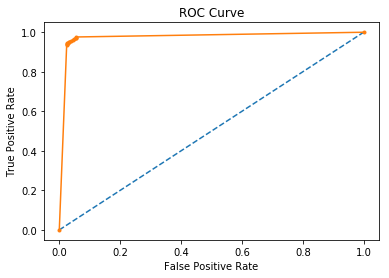

In [10]:
CART = DecisionTreeClassifier()
CART.fit(X_train, y_train)
y_pred = CART.predict(X_test)

model_eval(y_test, y_pred)

print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('CROSS VALIDATION')
cross_validation(5, CART, features, labels)
print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('ROC CURVE')
plot_roc_curve(CART, X_test, y_test)

#### Decision Rules

In [15]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    
print(tree_to_code(CART.fit(X_train, y_train),features.columns.values))

def tree(having_IP_Address, URL_Length, Shortining_Service, having_At_Symbol, double_slash_redirecting, Prefix_Suffix, having_Sub_Domain, SSLfinal_State, Domain_registeration_length, Favicon, port, HTTPS_token, Request_URL, URL_of_Anchor, Links_in_tags, SFH, Submitting_to_email, Abnormal_URL, Redirect, on_mouseover, RightClick, popUpWidnow, Iframe, age_of_domain, DNSRecord, web_traffic, Page_Rank, Google_Index, Links_pointing_to_page, Statistical_report):
  if SSLfinal_State <= 0.5:
    if Prefix_Suffix <= 0.0:
      if URL_of_Anchor <= -0.5:
        return [[2254.    0.]]
      else:  # if URL_of_Anchor > -0.5
        if Links_in_tags <= -0.5:
          if web_traffic <= 0.5:
            if HTTPS_token <= 0.0:
              if Links_pointing_to_page <= 0.5:
                return [[24.  0.]]
              else:  # if Links_pointing_to_page > 0.5
                if having_IP_Address <= 0.0:
                  return [[5. 0.]]
                else:  # if having_IP_Address > 0.0
         

In [14]:
print(list(zip(features.columns[CART.tree_.feature], CART.tree_.threshold, CART.tree_.children_left, CART.tree_.children_right))[0:50])

[('SSLfinal_State', 0.5, 1, 318), ('Prefix_Suffix', 0.0, 2, 317), ('URL_of_Anchor', -0.5, 3, 4), ('Links_pointing_to_page', -2.0, -1, -1), ('Links_in_tags', -0.5, 5, 148), ('web_traffic', 0.5, 6, 49), ('HTTPS_token', 0.0, 7, 12), ('Links_pointing_to_page', 0.5, 8, 9), ('Links_pointing_to_page', -2.0, -1, -1), ('having_IP_Address', 0.0, 10, 11), ('Links_pointing_to_page', -2.0, -1, -1), ('Links_pointing_to_page', -2.0, -1, -1), ('having_Sub_Domain', 0.5, 13, 32), ('Request_URL', 0.0, 14, 15), ('Links_pointing_to_page', -2.0, -1, -1), ('Page_Rank', 0.0, 16, 31), ('Redirect', 0.5, 17, 28), ('having_Sub_Domain', -0.5, 18, 27), ('DNSRecord', 0.0, 19, 20), ('Links_pointing_to_page', -2.0, -1, -1), ('web_traffic', -0.5, 21, 22), ('Links_pointing_to_page', -2.0, -1, -1), ('Domain_registeration_length', 0.0, 23, 26), ('Links_pointing_to_page', 0.5, 24, 25), ('Links_pointing_to_page', -2.0, -1, -1), ('Links_pointing_to_page', -2.0, -1, -1), ('Links_pointing_to_page', -2.0, -1, -1), ('Links_point

## Random Forest



CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,1206,31
Legitimate,44,1168




             precision    recall  f1-score   support

   Phishing       0.96      0.97      0.97      1237
 Legitimate       0.97      0.96      0.97      1212

avg / total       0.97      0.97      0.97      2449



-------------------------------------------------------------------
-------------------------------------------------------------------


CROSS VALIDATION
Test data set average precision across 5 folds:
[0.97102872 0.9683693  0.96909295 0.96425698 0.96279866]

Test data set average recall across 5 folds:
[0.97091837 0.96836735 0.96887755 0.96424923 0.96271706]

Test data set average fscore across 5 folds:
[0.97091666 0.96836731 0.96887398 0.96424908 0.96271541]


CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,4702,196
Legitimate,195,4703




             precision    recall  f1-score   support

   Phishing       0.96      0.96      0.96      4898
 Legitimate       0.96      0.96      0.96      4898

avg / total       0.96      0.96      0.96      9796



-------------------------------------------------------------------
-------------------------------------------------------------------


ROC CURVE
AUC: 0.994


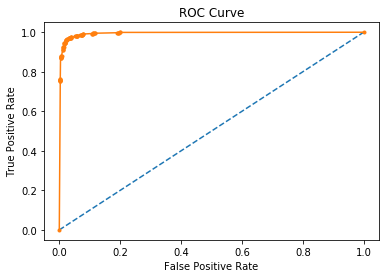

In [11]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

model_eval(y_test, y_pred)

print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('CROSS VALIDATION')
cross_validation(5, RF, features, labels)
print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('ROC CURVE')
plot_roc_curve(RF, X_test, y_test)

## K Nearest Neighbor



CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,1182,55
Legitimate,123,1089




             precision    recall  f1-score   support

   Phishing       0.91      0.96      0.93      1237
 Legitimate       0.95      0.90      0.92      1212

avg / total       0.93      0.93      0.93      2449



-------------------------------------------------------------------
-------------------------------------------------------------------


CROSS VALIDATION
Test data set average precision across 5 folds:
[0.93596716 0.93360841 0.93101083 0.93334359 0.92669036]

Test data set average recall across 5 folds:
[0.93520408 0.93265306 0.93010204 0.93207354 0.92492339]

Test data set average fscore across 5 folds:
[0.93517572 0.93261595 0.93006518 0.93202374 0.92484559]


CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,4698,200
Legitimate,201,4697




             precision    recall  f1-score   support

   Phishing       0.96      0.96      0.96      4898
 Legitimate       0.96      0.96      0.96      4898

avg / total       0.96      0.96      0.96      9796



-------------------------------------------------------------------
-------------------------------------------------------------------


ROC CURVE
AUC: 0.982


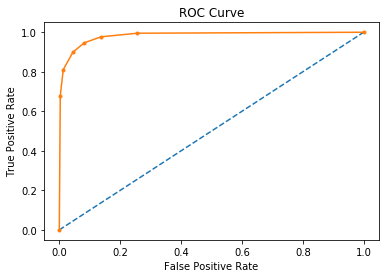

In [12]:
KNN = KNeighborsClassifier(n_neighbors=6)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

model_eval(y_test, y_pred)

print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('CROSS VALIDATION')
cross_validation(5, KNN, features, labels)
print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('ROC CURVE')
plot_roc_curve(KNN, X_test, y_test)

## Logistic Regression



CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,1144,93
Legitimate,94,1118




             precision    recall  f1-score   support

   Phishing       0.92      0.92      0.92      1237
 Legitimate       0.92      0.92      0.92      1212

avg / total       0.92      0.92      0.92      2449



-------------------------------------------------------------------
-------------------------------------------------------------------


CROSS VALIDATION
Test data set average precision across 5 folds:
[0.9284364  0.91413816 0.92746855 0.92850562 0.92594884]

Test data set average recall across 5 folds:
[0.92806122 0.91377551 0.92704082 0.92849847 0.92594484]

Test data set average fscore across 5 folds:
[0.92804547 0.91375663 0.92702256 0.92849817 0.92594467]


CONFUSION MATRIX (predicted along top, actual along side): 


,Phishing,Legitimate
Phishing,4702,196
Legitimate,195,4703




             precision    recall  f1-score   support

   Phishing       0.96      0.96      0.96      4898
 Legitimate       0.96      0.96      0.96      4898

avg / total       0.96      0.96      0.96      9796



-------------------------------------------------------------------
-------------------------------------------------------------------


ROC CURVE
AUC: 0.977


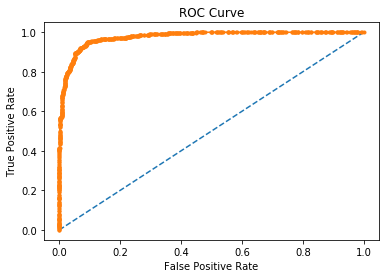

In [13]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

model_eval(y_test, y_pred)

print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('CROSS VALIDATION')
cross_validation(5, logreg, features, labels)
print('\n')
print('-------------------------------------------------------------------')
print('-------------------------------------------------------------------')
print('\n')
print('ROC CURVE')
plot_roc_curve(logreg, X_test, y_test)